# DeepLabV3 VOC 2012 and SBD 

In [2]:
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision
from torchvision import models
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
from PIL import Image
from collections import Counter
from sklearn.metrics import jaccard_score
import pickle
import my_datasets as mdset
from utils import * 




## Dataset : Pascal VOC 2012

In [3]:
dataroot_voc = '/data/voc2012'
dataroot_sbd = '/data/sbd'
model_name = 'dlv3_voc_sbd_100.pt'
SAVE_DIR = '/data/model'
save = os.path.join(SAVE_DIR,model_name)
batch_size = 4


In [4]:
train_dataset_VOC = mdset.VOCSegmentation(dataroot_voc,year='2012', image_set='train', download=True)

val_dataset_VOC = mdset.VOCSegmentation(dataroot_voc,year='2012', image_set='val', download=True)

Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar


In [5]:
train_dataset_SBD = mdset.SBDataset(dataroot_sbd, image_set='train_noval',mode='segmentation')

val_dataset_SBD = mdset.SBDataset(dataroot_sbd, image_set='val',mode='segmentation')

### Split dataset

In [6]:
#train_dataset_VOC = split_dataset(train_dataset_VOC,0.3)
#train_dataset_SBD = split_dataset(train_dataset_SBD,0.3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([500, 500, 3])


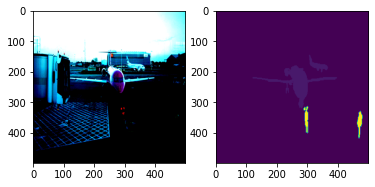

torch.Size([500, 500])

In [7]:
"""Pascal VOC Dataset Segmentation Dataloader"""


VOC_CLASSES = ('background',  # always index 0
               'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor')

NUM_CLASSES = len(VOC_CLASSES) + 1



sample = train_dataset_VOC.__getitem__(0)
image, mask = sample[0], sample[1]
#print(type(image))
#print(image.size())
image.transpose_(0, 2)
image.transpose_(0, 1)
print(image.size())

fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(image)    #.transpose(0,1)

a = fig.add_subplot(1,2,2)
plt.imshow(mask)

plt.show()
mask.size()


In [8]:

# Set batch_size
batch_size = 4

dataloader_train_VOC = torch.utils.data.DataLoader(train_dataset_VOC, batch_size=batch_size,drop_last=True)
dataloader_val_VOC = torch.utils.data.DataLoader(val_dataset_VOC, batch_size=batch_size)
dataloader_train_SBD = torch.utils.data.DataLoader(train_dataset_SBD, batch_size=batch_size,drop_last=True)
dataloader_val_SBD = torch.utils.data.DataLoader(val_dataset_SBD, batch_size=batch_size)
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device :",device)



device : cuda:0


In [9]:
print("Taille dataset train VOC :",len(train_dataset_VOC))
print("Taille dataset val VOC :",len(val_dataset_VOC))
print("Taille dataset train SBD :",len(train_dataset_SBD))
print("Taille dataset val SBD:",len(val_dataset_SBD))

Taille dataset train VOC : 1464
Taille dataset val VOC : 1449
Taille dataset train SBD : 5623
Taille dataset val SBD: 2857



## DeepLabV3 Pytorch

In [10]:
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=False)
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

## Training

In [11]:
learning_rate = 0.007
moment = 0.9
wd = 1e-4
n_epochs = 26
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=moment, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lambda x: (1 - x / ((len(dataloader_train_VOC)+len(dataloader_train_VOC)) * n_epochs)) ** 0.9)


#writer = SummaryWriter()
criterion = nn.CrossEntropyLoss(ignore_index=21) # On ignore la classe border.

In [12]:
iou_train = []
loss_train = []
iou_test = []
loss_test = []
all_loss_train = []
all_loss_test = []
all_iou = []

In [ ]:
for ep in range(n_epochs):
    print("EPOCH",ep)
    model.train()
    for i,(x,mask) in enumerate(dataloader_train_VOC):
          x = x.to(device)
          mask = mask.to(device)  
          pred = model(x)
          pred = pred["out"]
          loss = criterion(pred,mask)
          all_loss_train.append(loss.item())
          optimizer.zero_grad()
          loss.backward()
          all_iou.append(inter_over_union(pred.argmax(dim=1).detach().cpu(),mask.detach().cpu()))
          optimizer.step()
            
    for i,(x,mask) in enumerate(dataloader_train_SBD):
          x = x.to(device)
          mask = mask.to(device)
          pred = model(x)
          pred = pred["out"]
          loss = criterion(pred,mask)
          all_loss_train.append(loss.item())
          optimizer.zero_grad()
          loss.backward()
          all_iou.append(inter_over_union(pred.argmax(dim=1).detach().cpu(),mask.detach().cpu()))
          optimizer.step()
          
          
    lr_scheduler.step()
    m_iou = np.array(all_iou).mean()
    m_loss = np.array(all_loss_train).mean()
    loss_train.append(m_loss)
    iou_train.append(m_iou)
    all_loss_train = []
    all_iou = []
    print("EP:",ep," loss train:",m_loss," iou train:",m_iou)
    model.eval()
    for i,(x,mask) in enumerate(dataloader_val_VOC):
          x = x.to(device)
          mask = mask.to(device)
          with torch.no_grad():
            pred = model(x)
            pred = pred["out"]
          loss = criterion(pred,mask)
          all_loss_test.append(loss.item())
          all_iou.append(inter_over_union(pred.argmax(dim=1).detach().cpu(),mask.detach().cpu()))
    
    m_iou = np.array(all_iou).mean()
    m_loss = np.array(all_loss_test).mean()
    loss_test.append(m_loss)
    iou_test.append(m_iou)
    all_loss_test = []
    all_iou = []
    print("EP:",ep," loss test:",m_loss," iou test:",m_iou)


    torch.save(model,save)
    

EPOCH 0


/workspace/utils.py:117: RuntimeWarning: invalid value encountered in true_divide
  return np.nanmean(area_inter/area_union)


EP: 0  loss train: 0.7052993412865278  iou train: 0.14792232358511653
EP: 0  loss test: 0.5859514033580943  iou test: 0.3634441093746861
EPOCH 1
EP: 1  loss train: 0.4650514299656832  iou train: 0.2040854245171044
EP: 1  loss test: 0.7446741827099119  iou test: 0.3638176704487285
EPOCH 2


## Plot

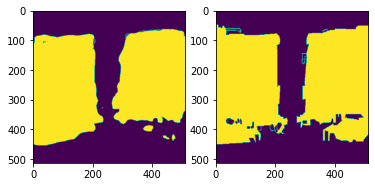

Classe prédite :  ['background', 'bus', 'train']
Classe réelle :  ['background', 'train']
0.9187138302763623
IOU sur ce masque : 0.8620561957359314


/workspace/utils.py:156: RuntimeWarning: invalid value encountered in true_divide
  acc_cls = np.diag(hist) / hist.sum(axis=1)
/workspace/utils.py:158: RuntimeWarning: invalid value encountered in true_divide
  iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))


In [20]:
x,mask = next(iter(dataloader_val_VOC))
i = 1
x = x.to(device)
mask = mask.to(device)
pred = model(x)
pred = pred["out"]
fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(pred.max(dim=1)[1][i].cpu())

a = fig.add_subplot(1,2,2)
plt.imshow(mask.cpu().detach().numpy()[i])

plt.show()

class_pred = []
class_mask = []

for p in pred.argmax(dim=1)[i].unique():
  class_pred.append(VOC_CLASSES[int(p)])
for m in mask[i].unique():
  class_mask.append(VOC_CLASSES[int(m)])

print("Classe prédite : ",class_pred)
print("Classe réelle : ",class_mask)
print(scores(pred.argmax(dim=1)[i],mask[i])["Pixel Accuracy"])
print("IOU sur ce masque :",float(iou(pred.argmax(dim=1)[i].unsqueeze(0),mask[i].unsqueeze(0))))


Text(0, 0.5, 'Mean IOU')

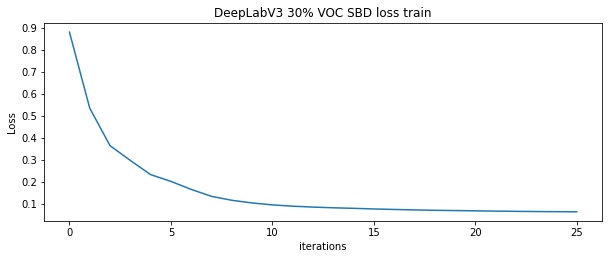

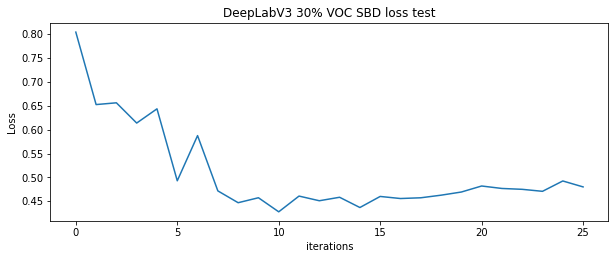

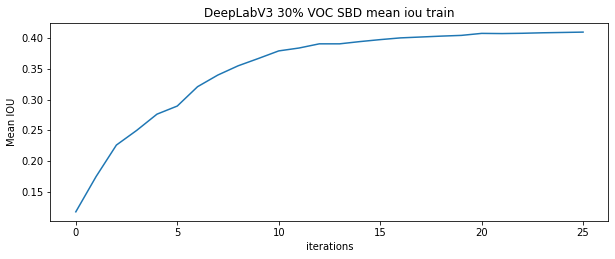

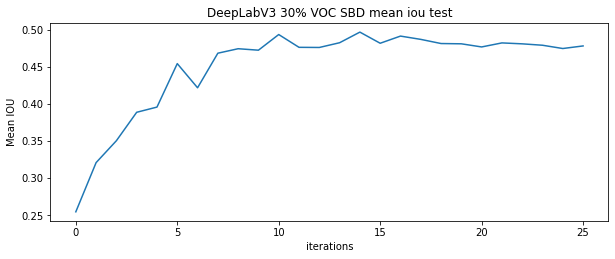

In [22]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("DeepLabV3 30% VOC SBD loss train")
plt.plot(loss_train)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("DeepLabV3 30% VOC SBD loss test")
plt.plot(loss_test)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("DeepLabV3 30% VOC SBD mean iou train")
plt.plot(iou_train)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("DeepLabV3 30% VOC SBD mean iou test")
plt.plot(iou_test)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")